In [1]:
import sys
sys.path.insert(0, '../')

import torch
import numpy as np
import pylab as plt

from models import build_model
from datasets import build_dataset, build_ood_datasets
from metrics import calibration, ood, generalization
from tqdm.auto import tqdm

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Loading model
checkpoint = torch.load('../results/CIFAR10__wideresnet2810_mcdropout/seed1/checkpoint.pth')
model_dict = build_model(checkpoint['args'], n_classes=10, train_ds=None)
model = model_dict['model']
model.load_state_dict(checkpoint['model'])

# Load datasets
train_ds, test_ds, ds_info = build_dataset(checkpoint['args'])
ood_datasets = build_ood_datasets(checkpoint['args'], ds_info['mean'], ds_info['std'])
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256, sampler=None)# range(1000))
ood_loader = torch.utils.data.DataLoader(ood_datasets['SVHN'], batch_size=256, sampler=None)# range(1000))

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


In [9]:
# forward prop
device = 'cuda'
model.to(device)
model.eval()

logits, targets = [], []
for inp, tar in tqdm(test_loader):
    with torch.no_grad():
        logits.append(model.mc_forward(inp.to(device), k=4).cpu())
        targets.append(tar)
logits = torch.cat(logits)
targets = torch.cat(targets)

logits_ood = []
for inp, tar in tqdm(ood_loader):
    with torch.no_grad():
        logits_ood.append(model.mc_forward(inp.to(device), k=4).cpu())
logits_ood = torch.cat(logits_ood)

100%|██████████| 102/102 [01:17<00:00,  1.32it/s]


In [11]:
# Compute results
probas_id = logits.softmax(-1).mean(1)
probas_ood = logits_ood.softmax(-1).mean(1)
entropy_id = ood.entropy_fn(probas_id)
entropy_ood = ood.entropy_fn(probas_ood)
tce_criterion = calibration.TopLabelCalibrationError()
nll_criterion = torch.nn.NLLLoss()

results = {
    'ACC': generalization.accuracy(probas_id, targets)[0].item(),
    'TCE': tce_criterion(probas_id, targets).item(),
    'NLL': nll_criterion(probas_id.log(), targets).item(),
    'AUROC': ood.ood_auroc(entropy_id, entropy_ood)
}
print(results)

{'ACC': 96.3699951171875, 'TCE': 0.015845004469156265, 'NLL': 0.1344233751296997, 'AUROC': 0.955393565611555}


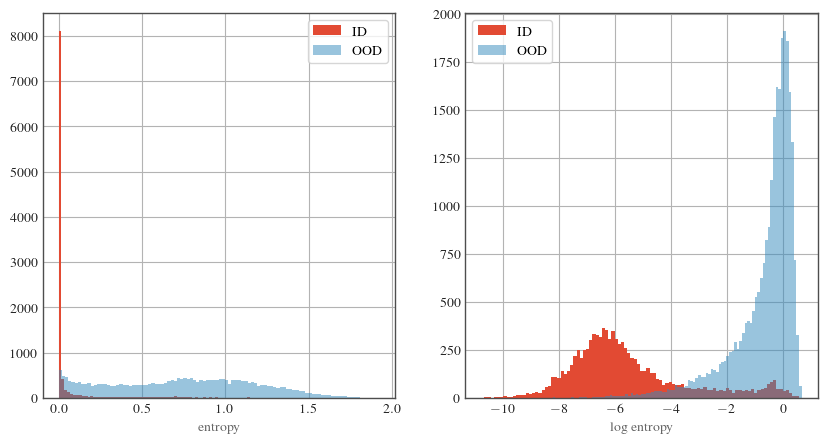

In [12]:
# Plot ood histogram
plt.subplot(121)
plt.hist(entropy_id, bins=100, label='ID')
plt.hist(entropy_ood, bins=100, alpha=.5, label='OOD')
plt.xlabel('entropy')

plt.legend()
plt.subplot(122)
plt.hist(entropy_id.log(), bins=100, label='ID')
plt.hist(entropy_ood.log(), bins=100, alpha=.5, label='OOD')
plt.xlabel('log entropy')
plt.legend()
plt.show()

<BarContainer object of 15 artists>

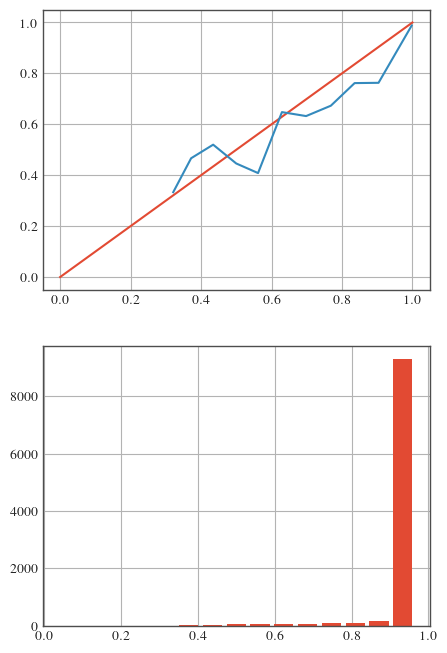

In [13]:
# Plot reliability diagram
tcp_dict = tce_criterion.results
plt.figure(figsize=(5, 8))
plt.subplot(211)
plt.plot([0, 1], [0, 1])
plt.plot(tcp_dict['confs'], tcp_dict['accs'])
plt.subplot(212)
plt.bar(np.linspace(1/15, 1-1/15, 15), tcp_dict['n_samples'], width=.05)